#Load datasets



In [1]:
import albumentations as A
import cv2
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import torch
path = '/content/drive/MyDrive/DL/coco.pt'            #coco.pt has 10,000 preprossed image and it's captions for image captioning (from coco dataset)
m =torch.load(path)

In [4]:
#print(m)    #m is an dictionary with the key 'train_images' for images and 'train_captions' for the image captions

In [5]:
m['train_images'].shape

torch.Size([10000, 3, 112, 112])

In [6]:
m['train_captions'].shape

torch.Size([10000, 17])

In [7]:
m['train_captions'][0]

tensor([  1,  15, 175,  19,   8, 132, 690,   4,  73,  10,  28, 146,   2,   0,
          0,   0,   0])

In [49]:
#m['vocab'][ 'token_to_idx']  #idx_to_token and  'token_to_idx'

#Start is 1 and end is 2

In [9]:
m['vocab'][ 'token_to_idx']['that']

25

In [10]:
max(m['vocab'][ 'token_to_idx'].values())  #we have 864 words in the dict including stop, start, end etc.

863

In [11]:
m['vocab'][ 'idx_to_token'][25]   #This is the way to excess the word when we have index

'that'

In [12]:
#Function to generate the sentence from the indexes for the given image

def generate_caption(caption):
  cc = caption.clone().cpu()
  sentence = ''
  for i in cc:
    sentence += m['vocab'][ 'idx_to_token'][i] 
    sentence += ' '

  return sentence




In [13]:
generate_caption(m['train_captions'][10])

'<START> a table with a blender and a glass on it <END> <NULL> <NULL> <NULL> <NULL> <NULL> '

#Dividing the dataset into train and Validation data

In [14]:
images = m['train_images'][0:9990]
captions = m['train_captions'][0:9990]

In [15]:
val = m['train_images'][9990:10000]
val_captions = m['train_captions'][9990:10000]

##Visualizing the Final data

In [16]:
#Shapes of images and captions for training

print("Shapes of final images: ", images.shape)
print("Shapes of final captions: ", captions.shape)

Shapes of final images:  torch.Size([9990, 3, 112, 112])
Shapes of final captions:  torch.Size([9990, 17])


In [17]:
#Shapes of validation dataset

print("Shapes of final images in validation data: ", val.shape)
print("Shapes of final captions in validation data: ", val_captions.shape)   #10 images in the validation data

Shapes of final images in validation data:  torch.Size([10, 3, 112, 112])
Shapes of final captions in validation data:  torch.Size([10, 17])


Image: 


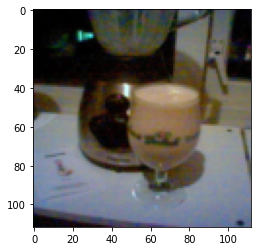

It's captions: 
<START> a table with a blender and a glass on it <END> <NULL> <NULL> <NULL> <NULL> <NULL> 


In [18]:
#Displaying one image with it's captions:
import matplotlib.pyplot as plt 
import numpy as np

idx = 10
print("Image: ")
plt.imshow((images[idx].permute(1,2,0)).numpy())
plt.show()

print("It's captions: ")
print(generate_caption(captions[idx]))

In [19]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [20]:
images = torch.tensor(images.clone().detach(), device= DEVICE, dtype= torch.float32)
captions = torch.tensor(captions.clone().detach(), device= DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [21]:
val = torch.tensor(val.clone().detach(), device= DEVICE, dtype= torch.float32)
val_captions = torch.tensor(val_captions.clone().detach(), device= DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


#Building the forward pass

we will use Attention Layer in the Vanilla RNN for image captioning.

Credits for the photo: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

##Attention RNN
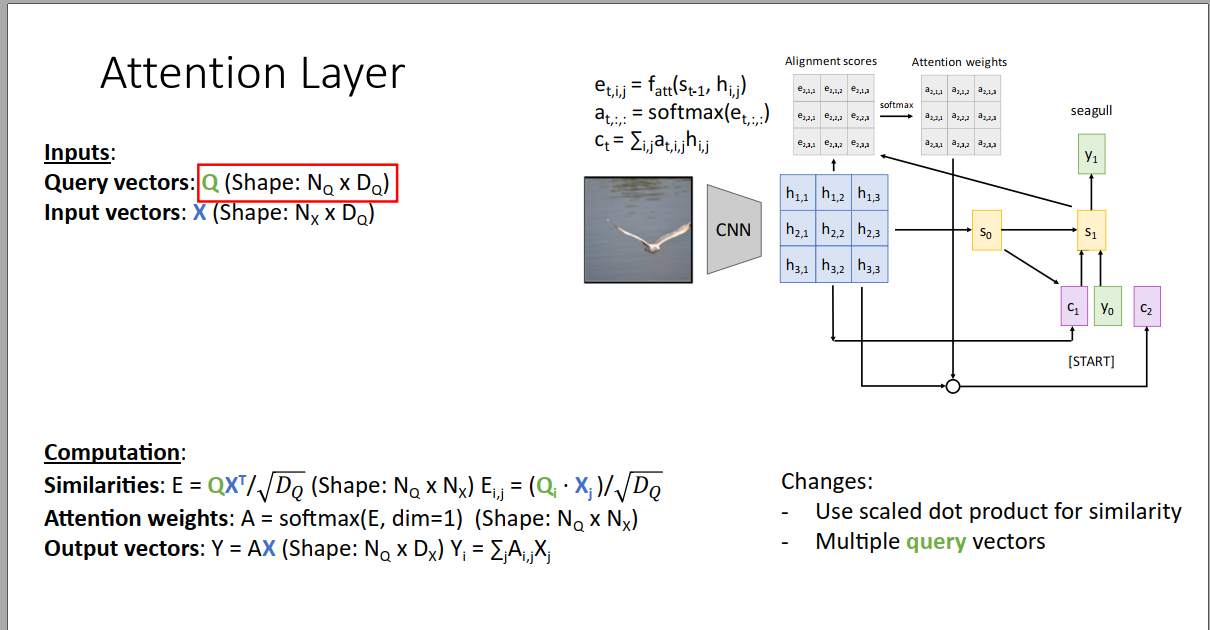![image.png]

##Feature Extractor
Using VGG-19 as feature extractor

In [22]:
#Using VGG-19 as feature extractor

from torchvision.models.vgg import vgg19
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for vgg19.
backbone_model = vgg19(pretrained= True).to(DEVICE)
train_nodes, eval_nodes = get_graph_node_names(vgg19())

#Doing requiregrsd =False for pretrained model
for param in backbone_model.parameters():
    param.requires_grad = False

backbone_model.requires_grad_(False)
backbone_model.eval()  

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:
print(train_nodes)
print(eval_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'fea

In [24]:
return_nodes = {
    # node_name: user-specified key for output dict
    'features.33': 'layer1'
}

In [25]:
backbone_feature_extractor = create_feature_extractor(backbone_model, return_nodes=return_nodes).to(DEVICE)

In [26]:
import torchvision
images = images/255.0

#Normalize
norm = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
images = norm(images)   #Don't plot the normalized images directly using matplotlib it will clip he negative values

In [27]:
val = val/255
val = norm(val)

In [28]:
def feature_extractor(img):  
  with torch.no_grad():
    out = backbone_feature_extractor(img)
    features = out['layer1']
  return features

In [29]:
feature_out = feature_extractor(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2]))
print("Output from the Feature extractor network (VGG19) for a single image: ", feature_out.shape)

Output from the Feature extractor network (VGG19) for a single image:  torch.Size([1, 512, 7, 7])


In [30]:
import math

#We can use this to initialize our weights and do forward pass (matrix multiplication)
vocab_size=15
embed_size=10

W_embed = nn.Parameter(
            torch.randn(vocab_size, embed_size).div(math.sqrt(vocab_size)) )
print(W_embed.shape)  #Basically it will make a matrix which will be an learnable weight matrix

torch.Size([15, 10])


In [31]:
#We can also use this to initialize our weights and do forward pass (matrix multiplication)
tryy = nn.Linear(vocab_size, embed_size)
mat = torch.ones(10,15)
tryy(mat).shape

torch.Size([10, 10])

In [32]:
a = torch.ones(10,512,7,7)
b = torch.ones(10,512)
print("a: ", a.shape)
print("b: ", b.shape)

a:  torch.Size([10, 512, 7, 7])
b:  torch.Size([10, 512])


In [33]:
#First dot product:
a = a.reshape(a.shape[0],a.shape[1],-1)
bnew = b.reshape(b.shape[0], 1, -1)
prod = bnew@a
#softmax
prod =  torch.softmax(prod, 2)
#Second dot product:
ans = prod@(a.permute(0,2,1))




In [34]:
ans.shape

torch.Size([10, 1, 512])

# Making Attention RNN architecture

In [35]:
class attention_rnn(nn.Module):

  def __init__(self, time_steps, word_size, embedding_size, feature_size, hidden_size):     #word size is the length of one hot encoded vector which goes as input to embedding layer 
    super(attention_rnn, self).__init__()

    self.word_size = word_size
    self.time_steps = time_steps
    self.hidden_size = hidden_size
    self.embedding = nn.Linear(word_size, embedding_size)    #one hot encoding goes here and produces input for the next hidden layer
    self.w_attention = nn.Linear(feature_size, hidden_size)           #
    self.wx = nn.Linear(embedding_size, hidden_size)
    self.wh = nn.Linear(hidden_size, hidden_size)

    self.output = nn.Linear(hidden_size, word_size)
    
  def forward(self, x, features):
    hidden = torch.rand((x.shape[1], self.hidden_size), device= DEVICE)
    
    output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

    for i in range(self.time_steps):

      #output = torch.zeros((self.time_steps, x.shape[1],self.word_size ), device= DEVICE)

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(x[i])

      #attention layer that will make to focus on certain parts of the input image

      #First dot product:
      a = features.reshape(features.shape[0],features.shape[1],-1)
      bnew = hidden.reshape(hidden.shape[0], 1, -1)
      prod = bnew@a/math.sqrt(512)
      #softmax
      prod =  torch.softmax(prod, 2)
      #Second dot product:
      ans = prod@(a.permute(0,2,1))
      ans = ans.reshape(ans.shape[0], ans.shape[2])
      features_focus = ans

      #passing the all required outputs to hidden layer and get hidden output h
      hidden = torch.tanh(self.w_attention(features_focus) + self.wx(out) + self.wh(hidden))

      y = self.output(hidden)

      output[i] = y

    return output


  def step_forward(self,features):

    input = torch.zeros(self.word_size, device= DEVICE)
    input[1] = 1.0

    hidden = torch.ones((1,self.hidden_size), device= DEVICE)
    

    out_f = []

    for i in range(self.time_steps):

      #Passing the one hot encoded input x to embedding layer:
      out = self.embedding(input)

      #attention layer that will make to focus on certain parts of the input image
      a = features.reshape(features.shape[0],features.shape[1],-1)
      bnew = hidden.reshape(hidden.shape[0], 1, -1)
      prod = bnew@a/math.sqrt(512)
      #softmax
      prod =  torch.softmax(prod, 2)
      #Second dot product:
      ans = prod@(a.permute(0,2,1))
      ans = ans.reshape(ans.shape[0], ans.shape[2])
      features_focus = ans
      
      #passing the all required outputs to hidden layer and get hidden output h
      hidden = torch.tanh(self.w_attention(features_focus) + self.wx(out) + self.wh(hidden))
      #print(hidden.shape)
      #print(self.wx(out).shape)
      #print(self.w_attention(features_focus).shape)


      y = self.output(hidden) 
      y = y.reshape(-1)
      #print(y.shape)     
      maxindx = torch.argmax(y)
      y[:] = 0
      y[maxindx] = 1
      input = y
      out_f.append(maxindx.cpu().numpy())
      hidden = hidden.reshape(1,-1)

    return torch.tensor(np.array(out_f), device= DEVICE)




   

In [36]:
ARNN = attention_rnn(time_steps=17, word_size=864, embedding_size=1000, feature_size=512, hidden_size=512).to(device=DEVICE)

In [37]:
ohc = F1.one_hot(captions, num_classes=864)   #  tHIS WILL do the one hot encoding part
print(ohc.shape)
ohcp = ohc.permute(1,0,2)
print(ohcp.shape)

print(ohcp[:,0,:])  #it works as expected

torch.Size([9990, 17, 864])
torch.Size([17, 9990, 864])
tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0')


#Training

In [38]:
optimizer = torch.optim.Adam(ARNN.parameters(), lr=0.001)        #update the weights of the RNN
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 500, gamma = 0.5)  

In [39]:
print(images.shape)
print(captions.shape)
print(ohcp.shape)

torch.Size([9990, 3, 112, 112])
torch.Size([9990, 17])
torch.Size([17, 9990, 864])


In [40]:
ohc = torch.tensor(ohc.detach().cpu().numpy(), device= DEVICE, dtype= torch.float32)

In [41]:
ohc.shape
y_target = torch.zeros_like(captions)
print(y_target.shape)

for i in range(y_target.shape[1]-1):

  y_target[:,i] = captions[:,i+1]

print(y_target.shape)

torch.Size([9990, 17])
torch.Size([9990, 17])


In [42]:
#Model Training
loss_graph = []
num_epochs = 4000
num_train = images.shape[0]
batch_size = 150
ARNN.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  imgf = images[random_no]
  x_batch = ohc[random_no]
  y_batch = y_target[random_no]

  x_batch = x_batch.permute(1,0,2)

  feat = feature_extractor(imgf)
  #print(feat.shape)
  
  optimizer.zero_grad()
  y_pred = ARNN.forward(x_batch, feat)
  y_pred = y_pred.permute(1,0,2)
  
 
  y_pred = y_pred.reshape(-1,864)
  y_batch = y_batch.reshape(-1)


  loss = loss_type(y_pred, y_batch )
  loss.backward()
  optimizer.step()
  #step_lr.step()
  loss_graph.append(loss.cpu().item())
  if i%25==0:
    print("Iteration: ", i, ", loss is: ", loss.cpu().item()) 

Iteration:  0 , loss is:  6.8719072341918945
Iteration:  25 , loss is:  3.4051191806793213
Iteration:  50 , loss is:  2.726356029510498
Iteration:  75 , loss is:  2.579247236251831
Iteration:  100 , loss is:  2.2953414916992188
Iteration:  125 , loss is:  2.1822149753570557
Iteration:  150 , loss is:  2.1046605110168457
Iteration:  175 , loss is:  1.9428998231887817
Iteration:  200 , loss is:  1.898305892944336
Iteration:  225 , loss is:  1.829036831855774
Iteration:  250 , loss is:  1.8439661264419556
Iteration:  275 , loss is:  1.7582511901855469
Iteration:  300 , loss is:  1.743873119354248
Iteration:  325 , loss is:  1.7214778661727905
Iteration:  350 , loss is:  1.6769567728042603
Iteration:  375 , loss is:  1.5939174890518188
Iteration:  400 , loss is:  1.6185181140899658
Iteration:  425 , loss is:  1.586672306060791
Iteration:  450 , loss is:  1.5496867895126343
Iteration:  475 , loss is:  1.5805866718292236
Iteration:  500 , loss is:  1.5240882635116577
Iteration:  525 , loss i

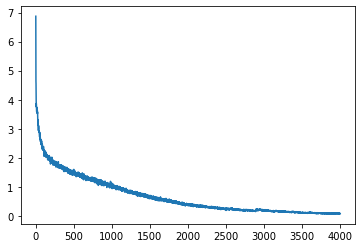

In [43]:
plt.plot(loss_graph)
plt.show()

#Predictions/Inference on Training Data

In [44]:
idx = 40
ARNN.eval()
ff1 = feature_extractor(images[idx].reshape(1, images[idx].shape[0], images[idx].shape[1], images[idx].shape[2]))
temp = ARNN.step_forward(ff1)
print("Generated captions by our model: ")
generate_caption(temp)

Generated captions by our model: 


'a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> <NULL> '

In [45]:
print("Actual captions: ")
generate_caption(captions[idx])

Actual captions: 


'<START> a man riding a white surfboard on a wave in the ocean <END> <NULL> <NULL> <NULL> '

#Predictions on Val Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


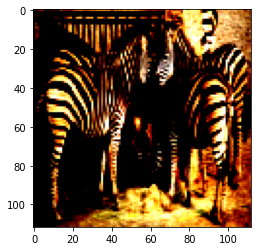

In [46]:
#image, may look strange as image is normalized image
idx = 7
plt.imshow(val[idx].permute(1,2,0).cpu().numpy())
plt.show()

In [47]:

ARNN.eval()
ff1 = feature_extractor(val[idx].reshape(1, val[idx].shape[0], val[idx].shape[1], val[idx].shape[2]))
temp = ARNN.step_forward(ff1)
print("Generated captions by our model: ")
generate_caption(temp)

Generated captions by our model: 


'a herd of zebras standing together by a grass covered field <END> <NULL> <NULL> <NULL> <NULL> <NULL> '

In [48]:
print("Actual captions: ")
generate_caption(val_captions[idx])

Actual captions: 


'<START> a group of zebra stand together eating hay <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> '